In [25]:
import cv2                                # state of the art computer vision algorithms library
import numpy as np                        # fundamental package for scientific computing
import matplotlib.pyplot as plt           # 2D plotting library producing publication quality figures

from PIL import Image
#from sklearn.cluster import MeanShift, estimate_bandwidth

In [61]:
def color_selection_mask(image, target_hsv=list):
    img_hsv = cv2.cvtColor(img_color, cv2.COLOR_BGR2HSV) 
    target_hsv = np.tile(target_hsv, (480, 640, 1))
    
    distance = np.zeros(img_hsv.shape)
    h_distance = np.minimum(np.abs(img_hsv[:,:,0:1] - target_hsv[:,:,0:1]), 180 - np.abs(img_hsv[:,:,0:1] - target_hsv[:,:,0:1]))
    sv_distance = img_hsv[:,:,1:] - target_hsv[:,:,1:]
    
    distance[:,:,0:1] = h_distance
    distance[:,:,1:] = sv_distance
    
    distance = np.linalg.norm(distance, axis=2)
    distance = 255 * distance / distance.max()
    distance = 255 - distance.astype(np.uint8)

    return distance


def auto_canny(image, sigma=0.33):
    # Compute the median of the single channel pixel intensities
    v = np.median(image)

    # Apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)

    return edged


def multiscale_template_matching(image, template_canny, max_scale=3, num_scales=31, do_visualize=False):    
    found = None
    template = template_canny #auto_canny(template) # Just pass in canny of template to save time
    (tH, tW) = template.shape[:2]
    
    # Loop over the scales of the image
    for scale in np.linspace(1, max_scale, num_scales)[::-1]:
        # Resize the image according to the scale, and keep track of the ratio of the resizing
        resized = cv2.resize(image, (0,0), fx=scale, fy=scale)
        r = image.shape[1] / float(resized.shape[1])
        # If the resized image is smaller than the template, then break from the loop
        if resized.shape[0] < tH or resized.shape[1] < tW:
            break
    
        # Detect edges in the resized, grayscale image and apply template matching to find the template in the image
        edged = auto_canny(resized)
        result = cv2.matchTemplate(edged, template, cv2.TM_CCOEFF)
        (_, maxVal, _, maxLoc) = cv2.minMaxLoc(result)
        
        # Check to see if the iteration should be visualized
        if do_visualize:
            # Draw a bounding box around the detected region
            clone = np.dstack([edged, edged, edged])
            cv2.rectangle(clone, (maxLoc[0], maxLoc[1]), (
                maxLoc[0] + tW, maxLoc[1] + tH), (0, 0, 255), 2)
            plt.imshow(clone)
            plt.show()
    
        # If we have found a new maximum correlation value, then update the bookkeeping variable
        if found is None or maxVal > found[0]:
            found = (maxVal, maxLoc, r)
    
    # Unpack the bookkeeping variable and compute the (x, y) coordinates of the bounding box based on the resized ratio
    (_, maxLoc, r) = found
    (startX, startY) = (int(maxLoc[0] * r), int(maxLoc[1] * r))
    (endX, endY) = (int((maxLoc[0] + tW) * r), int((maxLoc[1] + tH) * r))

    return {'box': ((startX, startY), (endX, endY)), 'scale': r}


def find_matching_boxes(image, template):
    # Parameters and their default values
    MAX_MATCHING_OBJECTS = 2

    # Find keypoints and descriptors for the template

    matched_boxes = []
    scales = []
    matching_img = image.copy()
    template_canny = auto_canny(template)

    for i in range(MAX_MATCHING_OBJECTS):
        # Find bounding boxes using template matching
        output = multiscale_template_matching(matching_img, template_canny)
        box = output['box']
        scale = output['scale']
        
        matched_boxes.append(box)
        scales.append(scale)
        
        if i == MAX_MATCHING_OBJECTS - 1:
            break
        
        # Create a mask and fill the matched area with near neighbors
        corners = np.array([[[box[0][0], box[0][1]]],
                            [[box[0][0], box[1][1]]],
                            [[box[1][0], box[1][1]]],
                            [[box[1][0], box[0][1]]]])
        mask = np.ones_like(matching_img) * 255
        cv2.fillPoly(mask, [np.int32(corners)], 0)
        mask = cv2.bitwise_not(mask)
        matching_img = cv2.inpaint(matching_img, mask, 3, cv2.INPAINT_TELEA)

        #plt.imshow(mask, 'gray')
        #plt.show()
        #plt.imshow(matching_img, 'gray')
        #plt.show()

    return matched_boxes, scales


def depth_from_boxes(depth, boxes):
    # Assume first box is always closest box, for now only works with 2 boxes
    fov_per_pix = 0.1491
    depth_scale = 0.0010000000474974513
    box1, box2 = matched_boxes

    # Get pixel dimentions and depth of closest box
    height_close_pixels = abs(box1[0][1] - box1[0][0])
    width_close_pixels = abs(box1[1][1] - box1[1][0])
    depth_close = np.median(depth[box1[0][1]:box1[1][1], box1[0][0]:box1[1][0]])  * depth_scale

    # Compute angular dimentions of closest box
    angular_size_height_close = height_close_pixels * fov_per_pix
    angular_size_width_close = width_close_pixels * fov_per_pix

    # Convert angular dimentions and stereo depth to physical dimentions of closest box
    height_close = 2 * depth_close * np.tan(np.deg2rad(angular_size_height_close)/2)
    width_close = 2 * depth_close * np.tan(np.deg2rad(angular_size_width_close)/2)

    # Get pixel dimentions of farther box
    height_far_pixels = abs(box2[0][1] - box2[0][0])
    width_far_pixels = abs(box2[1][1] - box2[1][0])
    depth_far = np.median(depth[box2[0][1]:box2[1][1], box2[0][0]:box2[1][0]]) * depth_scale

    # Compute angular dimentions of farther box
    angular_size_height_far = height_far_pixels * fov_per_pix
    angular_size_width_far = width_far_pixels * fov_per_pix

    # Compute depth angular dimentions known physical dimentions
    depth_from_height_far = height_close / (2 * np.tan(np.deg2rad(angular_size_height_far)/2))
    depth_from_width_far =  width_close / (2 * np.tan(np.deg2rad(angular_size_width_far)/2))
    depth_mean_far = np.mean([depth_from_height_far, depth_from_width_far])
    
    return [(None, depth_close), (depth_mean_far, depth_far)]

def lorde_from_roi(roi_coords, bgr_frame, depth):
    x1, x2, y1, y2 = roi_coords
    img = color_selection_mask(bgr_frame, [0, 255, 255])
    ref_img = img[y1:y2, x1:x2]
    matched_boxes, scales = find_matching_boxes(red_selection, ref_red_selection)
    computed_depths = depth_from_boxes(depth, matched_boxes)
    return {'matched_boxes': matched_boxes, 'computed_depths': computed_depths}

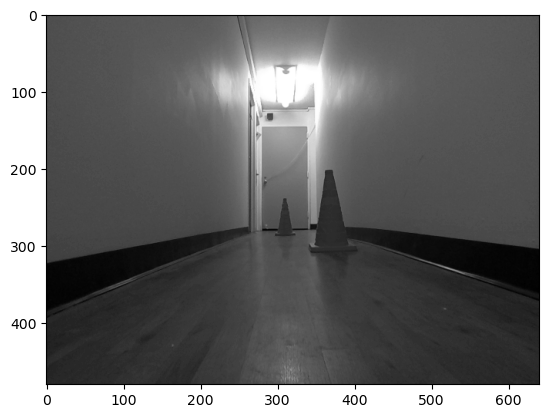

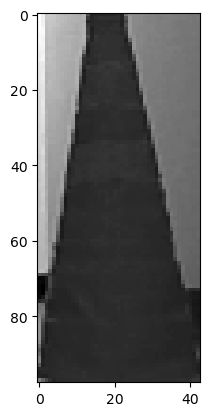

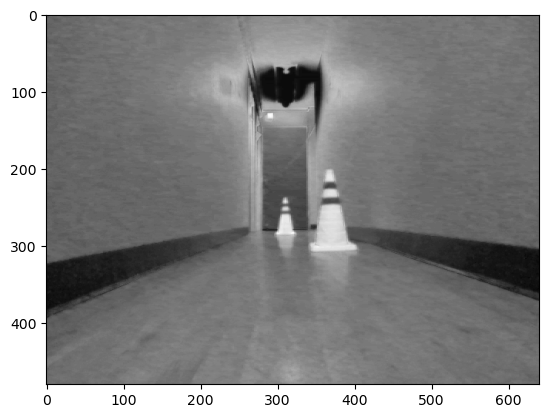

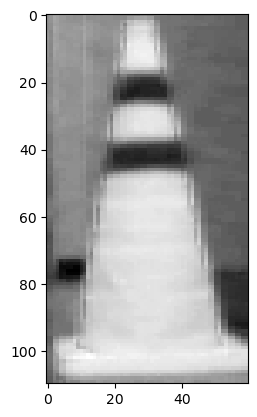

In [62]:
img_color = cv2.imread('calibration_images/cone_color2.png')
img = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
ref_obj = img[203:301, 349:392]
#ref_obj = img[200:310, 340:400]
#ref_obj = cv2.resize(ref_obj, (0,0), fx=0.5, fy=0.5)
#img_color = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
depth = np.load('calibration_images/cone_depth_array2.npy')

red_selection = color_selection_mask(img_color, [0, 255, 255])
ref_red_selection = red_selection[200:310, 340:400]

plt.imshow(img, 'gray'), plt.show()
plt.imshow(ref_obj, 'gray'), plt.show()
plt.imshow(red_selection, 'gray'), plt.show()
plt.imshow(ref_red_selection, 'gray')
plt.show()

In [63]:
#matched_boxes, scales = find_matching_boxes(red_selection, ref_red_selection)
#print(depth_from_boxes(depth, matched_boxes))
out = lorde_from_roi([340, 400, 200, 310], img_color, depth)
matched_boxes = out['matched_boxes']
computed_depths = out['computed_depths']

[(None, 1.6400000778958201), (4.142849496769565, 3.829000181867741)]


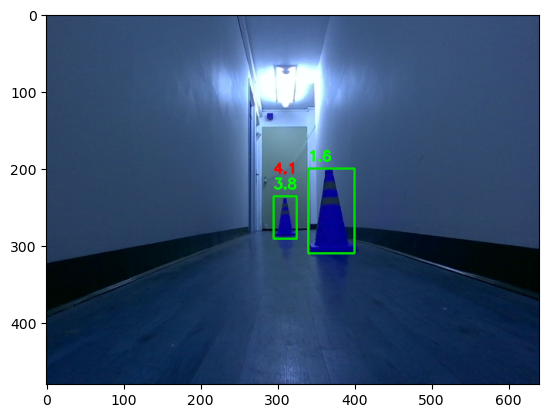

In [64]:
print(computed_depths)

for i, box in enumerate(matched_boxes):
    cv2.rectangle(img_color, box[0], box[1], (0, 225, 0), 2)

    computed_depth = computed_depths[i][0]
    realsense_depth = computed_depths[i][1]

    if computed_depth:
        computed_depth = "%.1f" % computed_depth
        cv2.putText(img_color, computed_depth, (box[0][0], box[0][1]-30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,0,0), 2)
    
    if realsense_depth:
        realsense_depth = "%.1f" % realsense_depth
        cv2.putText(img_color, realsense_depth, (box[0][0], box[0][1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)

plt.imshow(img_color)
plt.show()

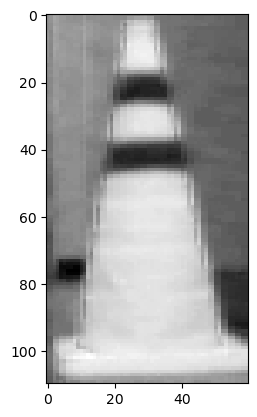

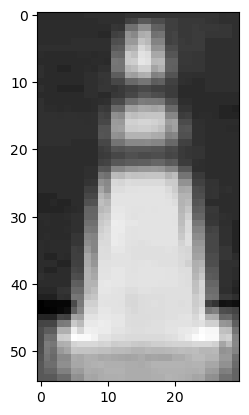

In [65]:
box1 = matched_boxes[0]
crop1 = red_selection[box1[0][1]:box1[1][1], box1[0][0]:box1[1][0]]
box2 = matched_boxes[1]
crop2 = red_selection[box2[0][1]:box2[1][1], box2[0][0]:box2[1][0]]

scale1, scale2 = scales
scale_ratio = scale1/scale2
#crop2 = cv2.resize(crop2, (0,0), fx=scale1/scale2, fy=scale1/scale2)

plt.imshow(crop1, 'gray')
plt.show()
plt.imshow(crop2, 'gray')
plt.show()

In [66]:
depth_scale = 0.0010000000474974513
depth_close = np.median(depth[box1[0][1]:box1[1][1], box1[0][0]:box1[1][0]]) * depth_scale
print(depth_close)
depth_far = np.median(depth[box2[0][1]:box2[1][1], box2[0][0]:box2[1][0]]) * depth_scale
print(depth_far)

1.6400000778958201
3.829000181867741


In [67]:
print(box2)

((295, 236), (325, 291))


In [69]:
# 0.1491 degrees per pixel

fov_per_pix = 0.1491

far_top_left = box2[0]
far_bottom_right = box2[1]

depth_scale = 0.0010000000474974513
depth_close = np.median(depth[box1[0][1]:box1[1][1], box1[0][0]:box1[1][0]])  * depth_scale

print('Height of close object in pixels', abs(box1[1][1] - box1[0][1]))
print('Width of close object in pixels', abs(box1[1][0] - box1[0][0]))
print('Depth of close object:', depth_close)

angular_size_height_close = abs(box1[1][1] - box1[0][1]) * fov_per_pix
angular_size_width_close = abs(box1[1][0] - box1[0][0]) * fov_per_pix

height_close = 2 * depth_close * np.tan(np.deg2rad(angular_size_height_close)/2)
width_close = 2 * depth_close * np.tan(np.deg2rad(angular_size_width_close)/2)

print('')
print('Height of close object', height_close)
print('Width of close object', width_close)

print('')
print('Height of far object in pixels', abs(box2[1][1] - box2[0][1]))
print('Width of far object in pixels', abs(box2[1][0] - box2[0][0]))

angular_size_height_far = abs(box2[1][1] - box2[0][1]) * fov_per_pix
angular_size_width_far = abs(box2[1][0] - box2[0][0]) * fov_per_pix

depth_from_height_far = height_close / (2 * np.tan(np.deg2rad(angular_size_height_far)/2))
depth_from_width_far =  width_close / (2 * np.tan(np.deg2rad(angular_size_width_far)/2))

print('')
print('Depth from height:', depth_from_height_far)
print('Depth from width:', depth_from_width_far)
print('Average depth:', np.mean([depth_from_height_far, depth_from_width_far]))

Height of close object in pixels 110
Width of close object in pixels 60
Depth of close object: 1.6400000778958201

Height of close object 0.47268446065294706
Width of close object 0.25658643077234744

Height of far object in pixels 55
Width of far object in pixels 30

Depth from height: 3.2969424140481647
Depth from width: 3.285010535191584
Average depth: 3.2909764746198746


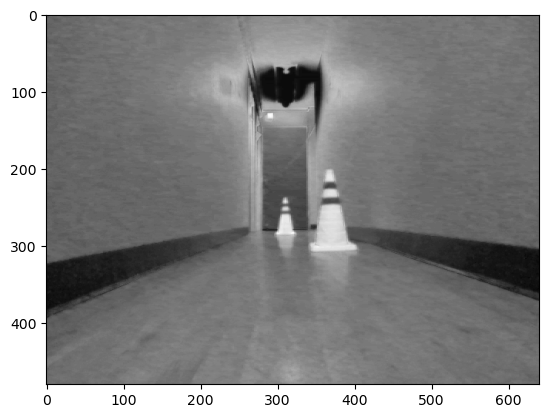

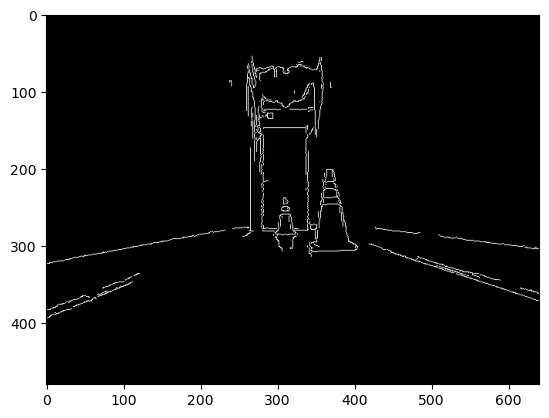

In [381]:
# Setting parameter values 
t_lower = 255/3 # Lower Threshold 
t_upper = 255  # Upper threshold 
aperture_size = 3

# Applying the Canny Edge filter 
#edge = cv2.Canny(img, t_lower, t_upper, apertureSize=aperture_size) 
edge = auto_canny(distance)

plt.imshow(distance, 'gray') 
plt.show()
plt.imshow(edge, 'gray') 
plt.show()

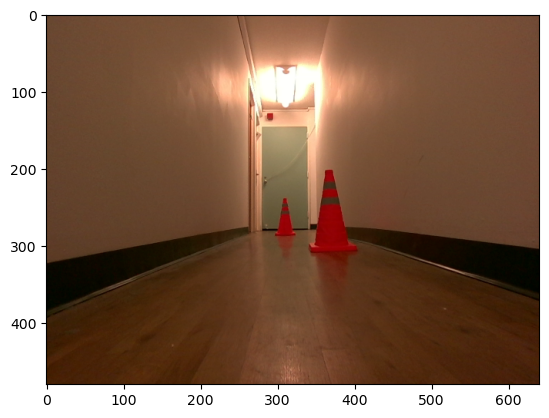

In [256]:
plt.imshow(img_color)
plt.show()

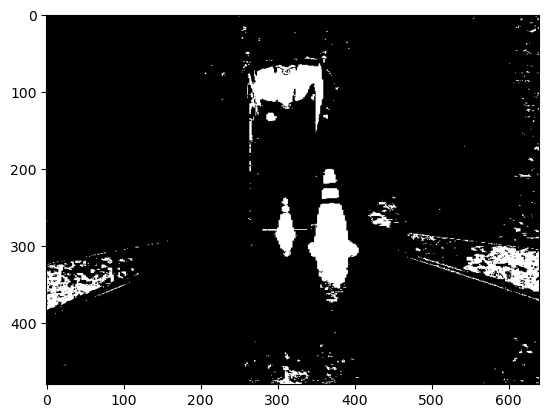

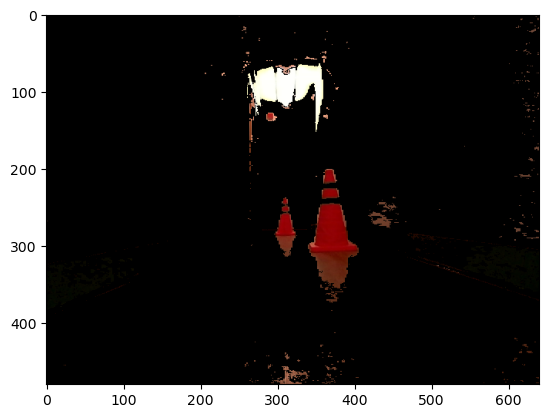

In [262]:
hsv = cv2.cvtColor(img_color, cv2.COLOR_RGB2HSV) 
      
# Threshold of orange in HSV space 
lower_orange = np.array([10, 0, 0]) 
upper_orange = np.array([25, 255, 255]) 

# preparing the mask to overlay 
mask = cv2.inRange(hsv, lower_orange, upper_orange) 

imask = mask > 0
imask = 1-imask
green = np.zeros_like(img_color, np.uint8)
green[imask] = img_color[imask]


# The black region in the mask has the value of 0, 
# so when multiplied with original image removes all non-blue regions 

mask = 255 - mask

result = cv2.bitwise_and(img_color, img_color, mask = mask) 

#plt.imshow(frame) 
plt.imshow(mask, 'gray') 
plt.show()
plt.imshow(result) 
plt.show()

In [ ]:
# Try computing distance from red in HSV space

In [3]:
img_hsv = cv2.cvtColor(img_color, cv2.COLOR_RGB2HSV) 
red_hsv = np.tile([0, 255, 255], (480, 640, 1))

distance = np.zeros(img_hsv.shape)
h_distance = np.minimum(np.abs(img_hsv[:,:,0:1] - red_hsv[:,:,0:1]), 180 - np.abs(img_hsv[:,:,0:1] - red_hsv[:,:,0:1]))
sv_distance = img_hsv[:,:,1:] - red_hsv[:,:,1:]

distance[:,:,0:1] = h_distance
distance[:,:,1:] = sv_distance

distance = np.linalg.norm(distance, axis=2)
distance = 255 * distance / distance.max()
distance = 255 - distance.astype(np.uint8)

In [1]:
plt.imshow(distance, 'gray')

NameError: name 'plt' is not defined

In [ ]:
np.tile(distance, (480, 640, 3)).shape

In [417]:
plt.imshow(distance.repeat(3, axis=1)/255 * img_color), plt.show()

ValueError: operands could not be broadcast together with shapes (480,1920) (480,640,3) 

In [19]:
# Initiate SIFT detector
sift = cv2.SIFT_create(nfeatures=150)
 
# Find the reference keypoints and descriptors with SIFT
ref_kp, ref_des = sift.detectAndCompute(crop1, None)

# Find the target image keypoints and descriptors with SIFT
img_kp, img_des = sift.detectAndCompute(crop2, None)

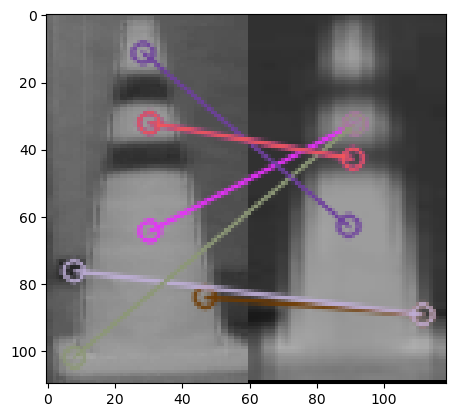

(<matplotlib.image.AxesImage at 0x13df56ca0>, None)

In [20]:
# import required libraries

# create BFMatcher object
bf = cv2.BFMatcher()

# Match descriptors.
matches = bf.match(ref_des, img_des)

# sort the matches based on distance
matches = sorted(matches, key=lambda val: val.distance)

#print(matches)

# Draw first 50 matches.
out = cv2.drawMatches(crop1, ref_kp, crop2, img_kp, matches[:10], None, flags=2)
plt.imshow(out, 'gray'), plt.show()

In [69]:
# TODO: Implement algorithm to find unspecified number of matches

In [70]:
# Find best matches of reference keypoints with target image keypoints
# Assume there are 2 matching objects in the image (for demo with cones)
matches = []
for i, (p1, d1) in enumerate(zip(ref_kp, ref_des)):
    best_match1 = None
    best_match2 = None
    best_match3 = None
    min_dist1 = np.inf
    min_dist2 = np.inf
    min_dist3 = np.inf
    
    for j, (p2, d2) in enumerate(zip(img_kp, img_des)):
        l2_dist = np.linalg.norm(np.array(d1) - np.array(d2)) 
        
        if l2_dist < min_dist1:
            # Bump down min_dist2 and min_dist1
            min_dist3 = min_dist2
            best_match3 = best_match2
            min_dist2 = min_dist1
            best_match2 = best_match1

            # Update min_dist1
            min_dist1 = l2_dist
            best_match1 = (j, l2_dist)
            
        elif l2_dist < min_dist2:
            # Bump down min_dist2
            min_dist3 = min_dist2
            best_match3 = best_match2

            # Update min_dist2
            min_dist2 = l2_dist
            best_match2 = (j, l2_dist)
            
        elif l2_dist < min_dist3:
            # Update min_dist3
            min_dist3 = l2_dist
            best_match3 = (j, l2_dist)
        
    matches.append((i, best_match1, best_match2, best_match3))

# Apply Lowe's ratio test
good = []
for i, m1, m2, m3 in matches:
    if m2[1] < 0.8*m3[1]:
        good.append((i, m1[0], m2[0]))
good = tuple(set([tuple(sorted(triple)) for triple in good]))

# Create list of matched_kps
matched_kp = []
matched_ref_kp = []
for i, idx1, idx2 in good:
    matched_ref_kp.append(ref_kp[i])
    matched_kp.append(img_kp[idx1])
    matched_kp.append(img_kp[idx2])

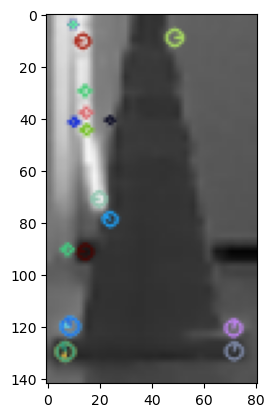

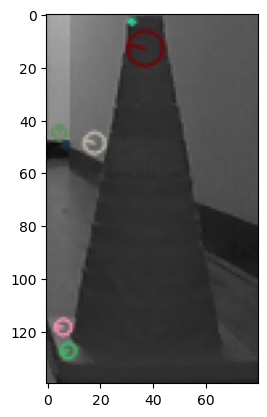

In [153]:
img_points = cv2.drawKeypoints(crop2, img_kp, img, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
ref_points = cv2.drawKeypoints(crop1, ref_kp, ref_obj, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img_points)
plt.show()
plt.imshow(ref_points)
plt.show()